# CODEX human ccRCC vessels

This example investigates differences in vascular niche characteristics between two human clear cell renal cell carcinoma (ccRCC) samples exhibiting distinct vessel branching patterns. Sample 4 represents a tumor characterized by a low-branching phenotype, while Sample 8 demonstrates a high-branching phenotype. To quantify and visualize the variation in cellular composition immediately adjacent to vessels, we utilize SPACEc's Patch Proximity Analysis (PPA). The original data are from this [study](https://www.medrxiv.org/content/10.1101/2025.06.05.25329017v1).

In [ ]:
import spacec as sp
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import warnings
warnings.filterwarnings("ignore")
output_dir = "/output/"

In [ ]:
adata = sc.read_h5ad("/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 832321 × 27
    obs: 'DAPI', 'x(um)', 'y(um)', 'area(um^2)', 'unique_region', 'ObjectID', 'leiden_gpu_1', 'broad_anno', 'subcluster_1', 'subcluster_1_anno', 'subcluster_2', 'subcluster_2_anno', 'subcluster_3', 'subcluster_3_anno', 'subcluster_4', 'subcluster_4_anno', 'batch', 'cell_type'
    uns: 'dendrogram_subcluster_4_anno', 'neighbors', 'subcluster_4_anno_colors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
# Create a color dictionary for cell types in adata.obs
# All cell types except 'Vessel' will be grey, while 'Vessel' will be red
color_dict = {ct: "red" if ct == "Vessel" else "grey" for ct in adata.obs["cell_type"].unique()}
print(color_dict)

{'Macrophage': 'grey', 'CD4+ T cell': 'grey', 'APC': 'grey', 'NK cell': 'grey', 'CD8+ T cell': 'grey', 'Granulocyte': 'grey', 'Treg': 'grey', 'mixed immune': 'grey', 'Monocyte': 'grey', 'Tumor': 'grey', 'Vessel': 'red', 'Smooth Muscle': 'grey'}


## Cell type composition

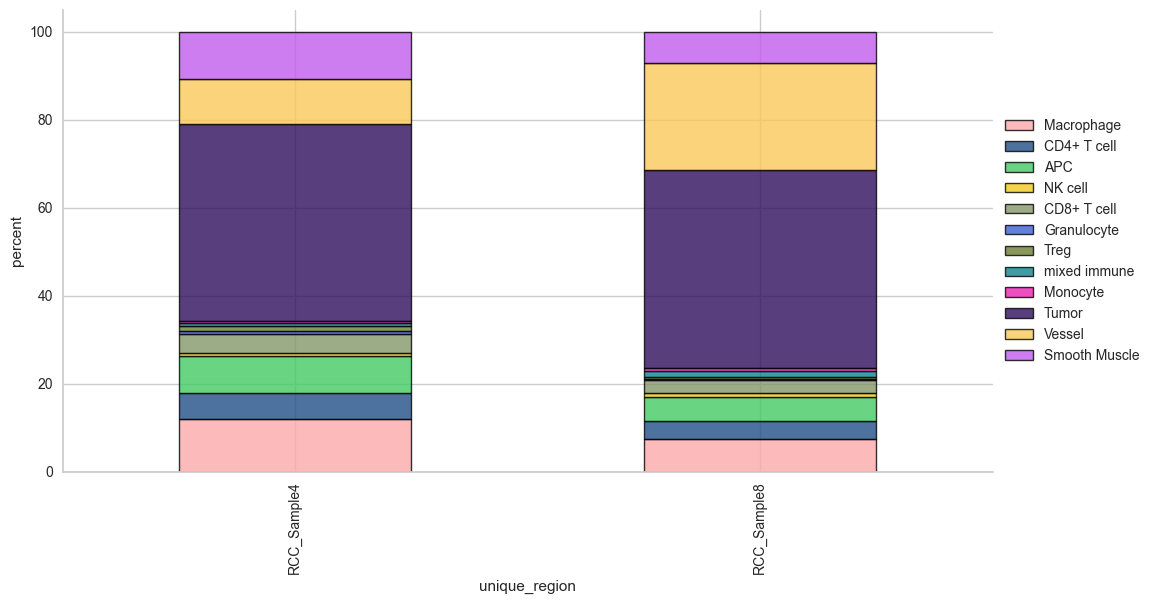

In [7]:
# cell type percentage tab and visualization [much few]
ct_perc_tab, _ = sp.pl.stacked_bar_plot(
    adata = adata, # adata object to use 
    color = 'cell_type', # column containing the categories that are used to fill the bar plot
    grouping = 'unique_region', # column containing a grouping variable (usually a condition or cell group) 
    cell_list = adata.obs['cell_type'].unique(),  # list of cell types to plot, you can also see the entire cell types adata.obs['celltype_fine'].unique()
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=True, # change it to true if you want to save the figure
    output_fname = "Barplot_cell_types", # change it to file name you prefer when saving the figure
    output_dir = output_dir, #output directory for the figure
    norm = False, # if True, then whatever plotted will be scaled to sum of 1
    fig_sizing= (12,6)
)


## Vessel tracing

In [5]:
adata.obs['vessel'] = adata.obs['cell_type'].apply(lambda x: 'Vessel' if x == 'Vessel' else 'Other')

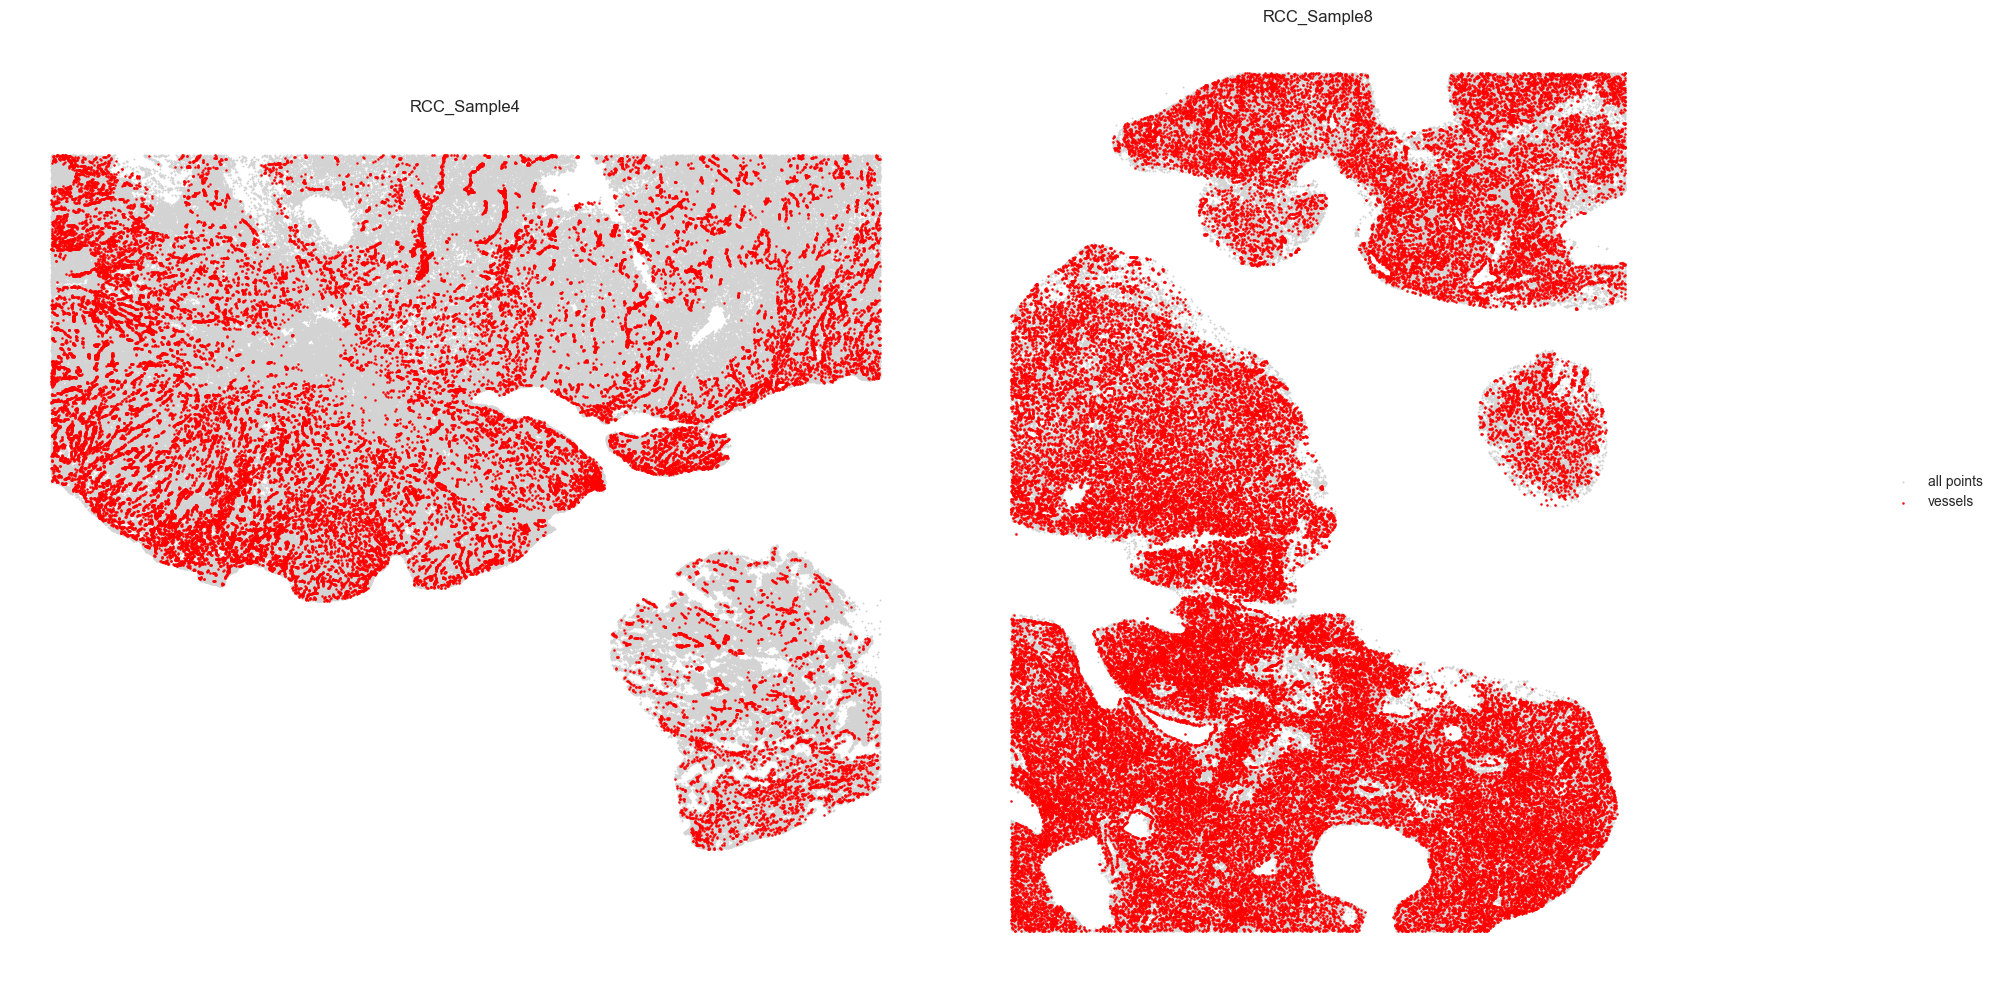

In [9]:
# Prepare vessel data
df = adata.obs[['x(um)', 'y(um)', 'vessel', 'unique_region']].copy()
df.columns = ['x', 'y', 'vessel', 'unique_region']

# Filter to vessels only
vessels = df[df['vessel'] == 'Vessel']

# Separate by region (adjust region names as needed)
vessels_A = vessels[vessels['unique_region'] == 'RCC_Sample4'].reset_index(drop=True)
vessels_B = vessels[vessels['unique_region'] == 'RCC_Sample8'].reset_index(drop=True)

def plot_vessels(ax, vessels, all_df, threshold, color):
    coords = vessels[['x', 'y']].to_numpy()
    tree = KDTree(coords)
    pairs = tree.query_pairs(r=threshold)
    
    # All points background
    ax.scatter(all_df['x'], all_df['y'], color='lightgray', s=1, label='all points')
    ax.scatter(vessels['x'], vessels['y'], color=color, s=2, label='vessels')
    
    for i, j in pairs:
        ax.plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color=color, linewidth=1)

    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{vessels["unique_region"].iloc[0]}')
    ax.set_frame_on(False)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
threshold = 5

plot_vessels(axes[0], vessels_A, df[df['unique_region'] == 'RCC_Sample4'], threshold, color='red')
plot_vessels(axes[1], vessels_B, df[df['unique_region'] == 'RCC_Sample8'], threshold, color='red')

# Move legend to the side
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', frameon=False)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space on the right for the legend
plt.show()


## Patch proximity analysis

Processing RCC_Sample4_Vessel
Estimated number of clusters: 3765
Estimated number of noise points: 5557
Finished RCC_Sample4_Vessel
Processing RCC_Sample8_Vessel
Estimated number of clusters: 7006
Estimated number of noise points: 16211
Finished RCC_Sample8_Vessel


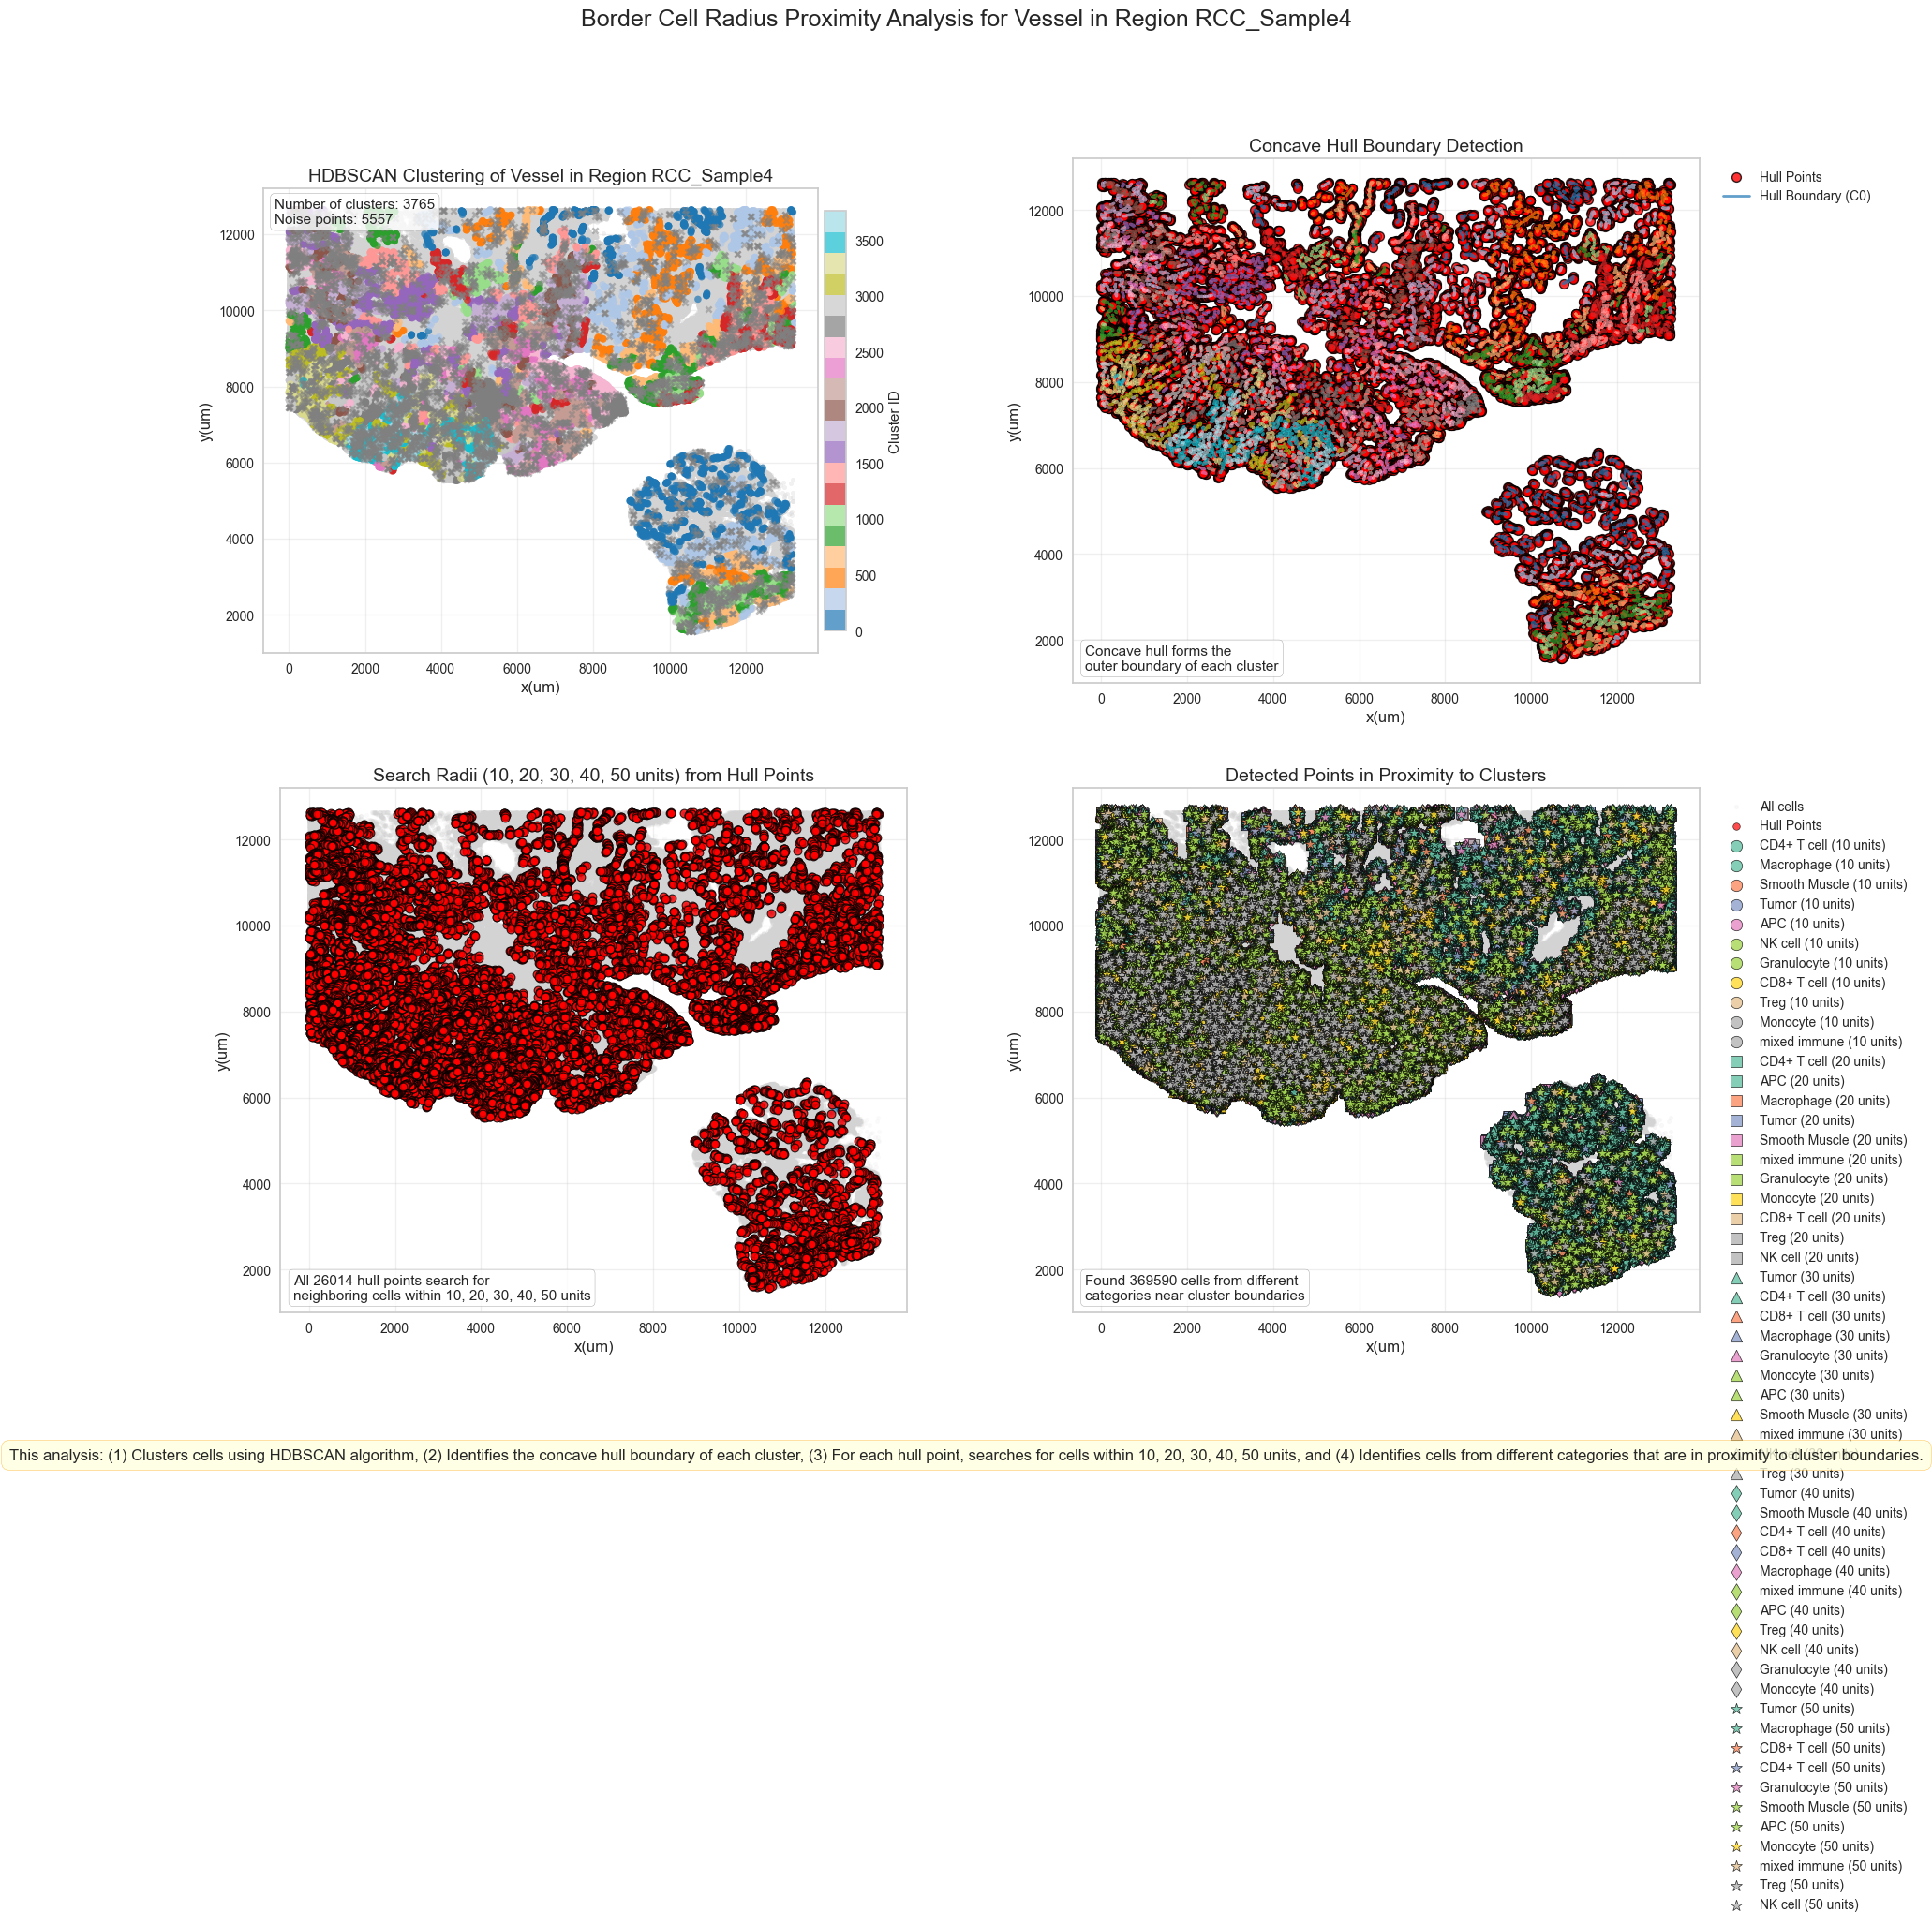

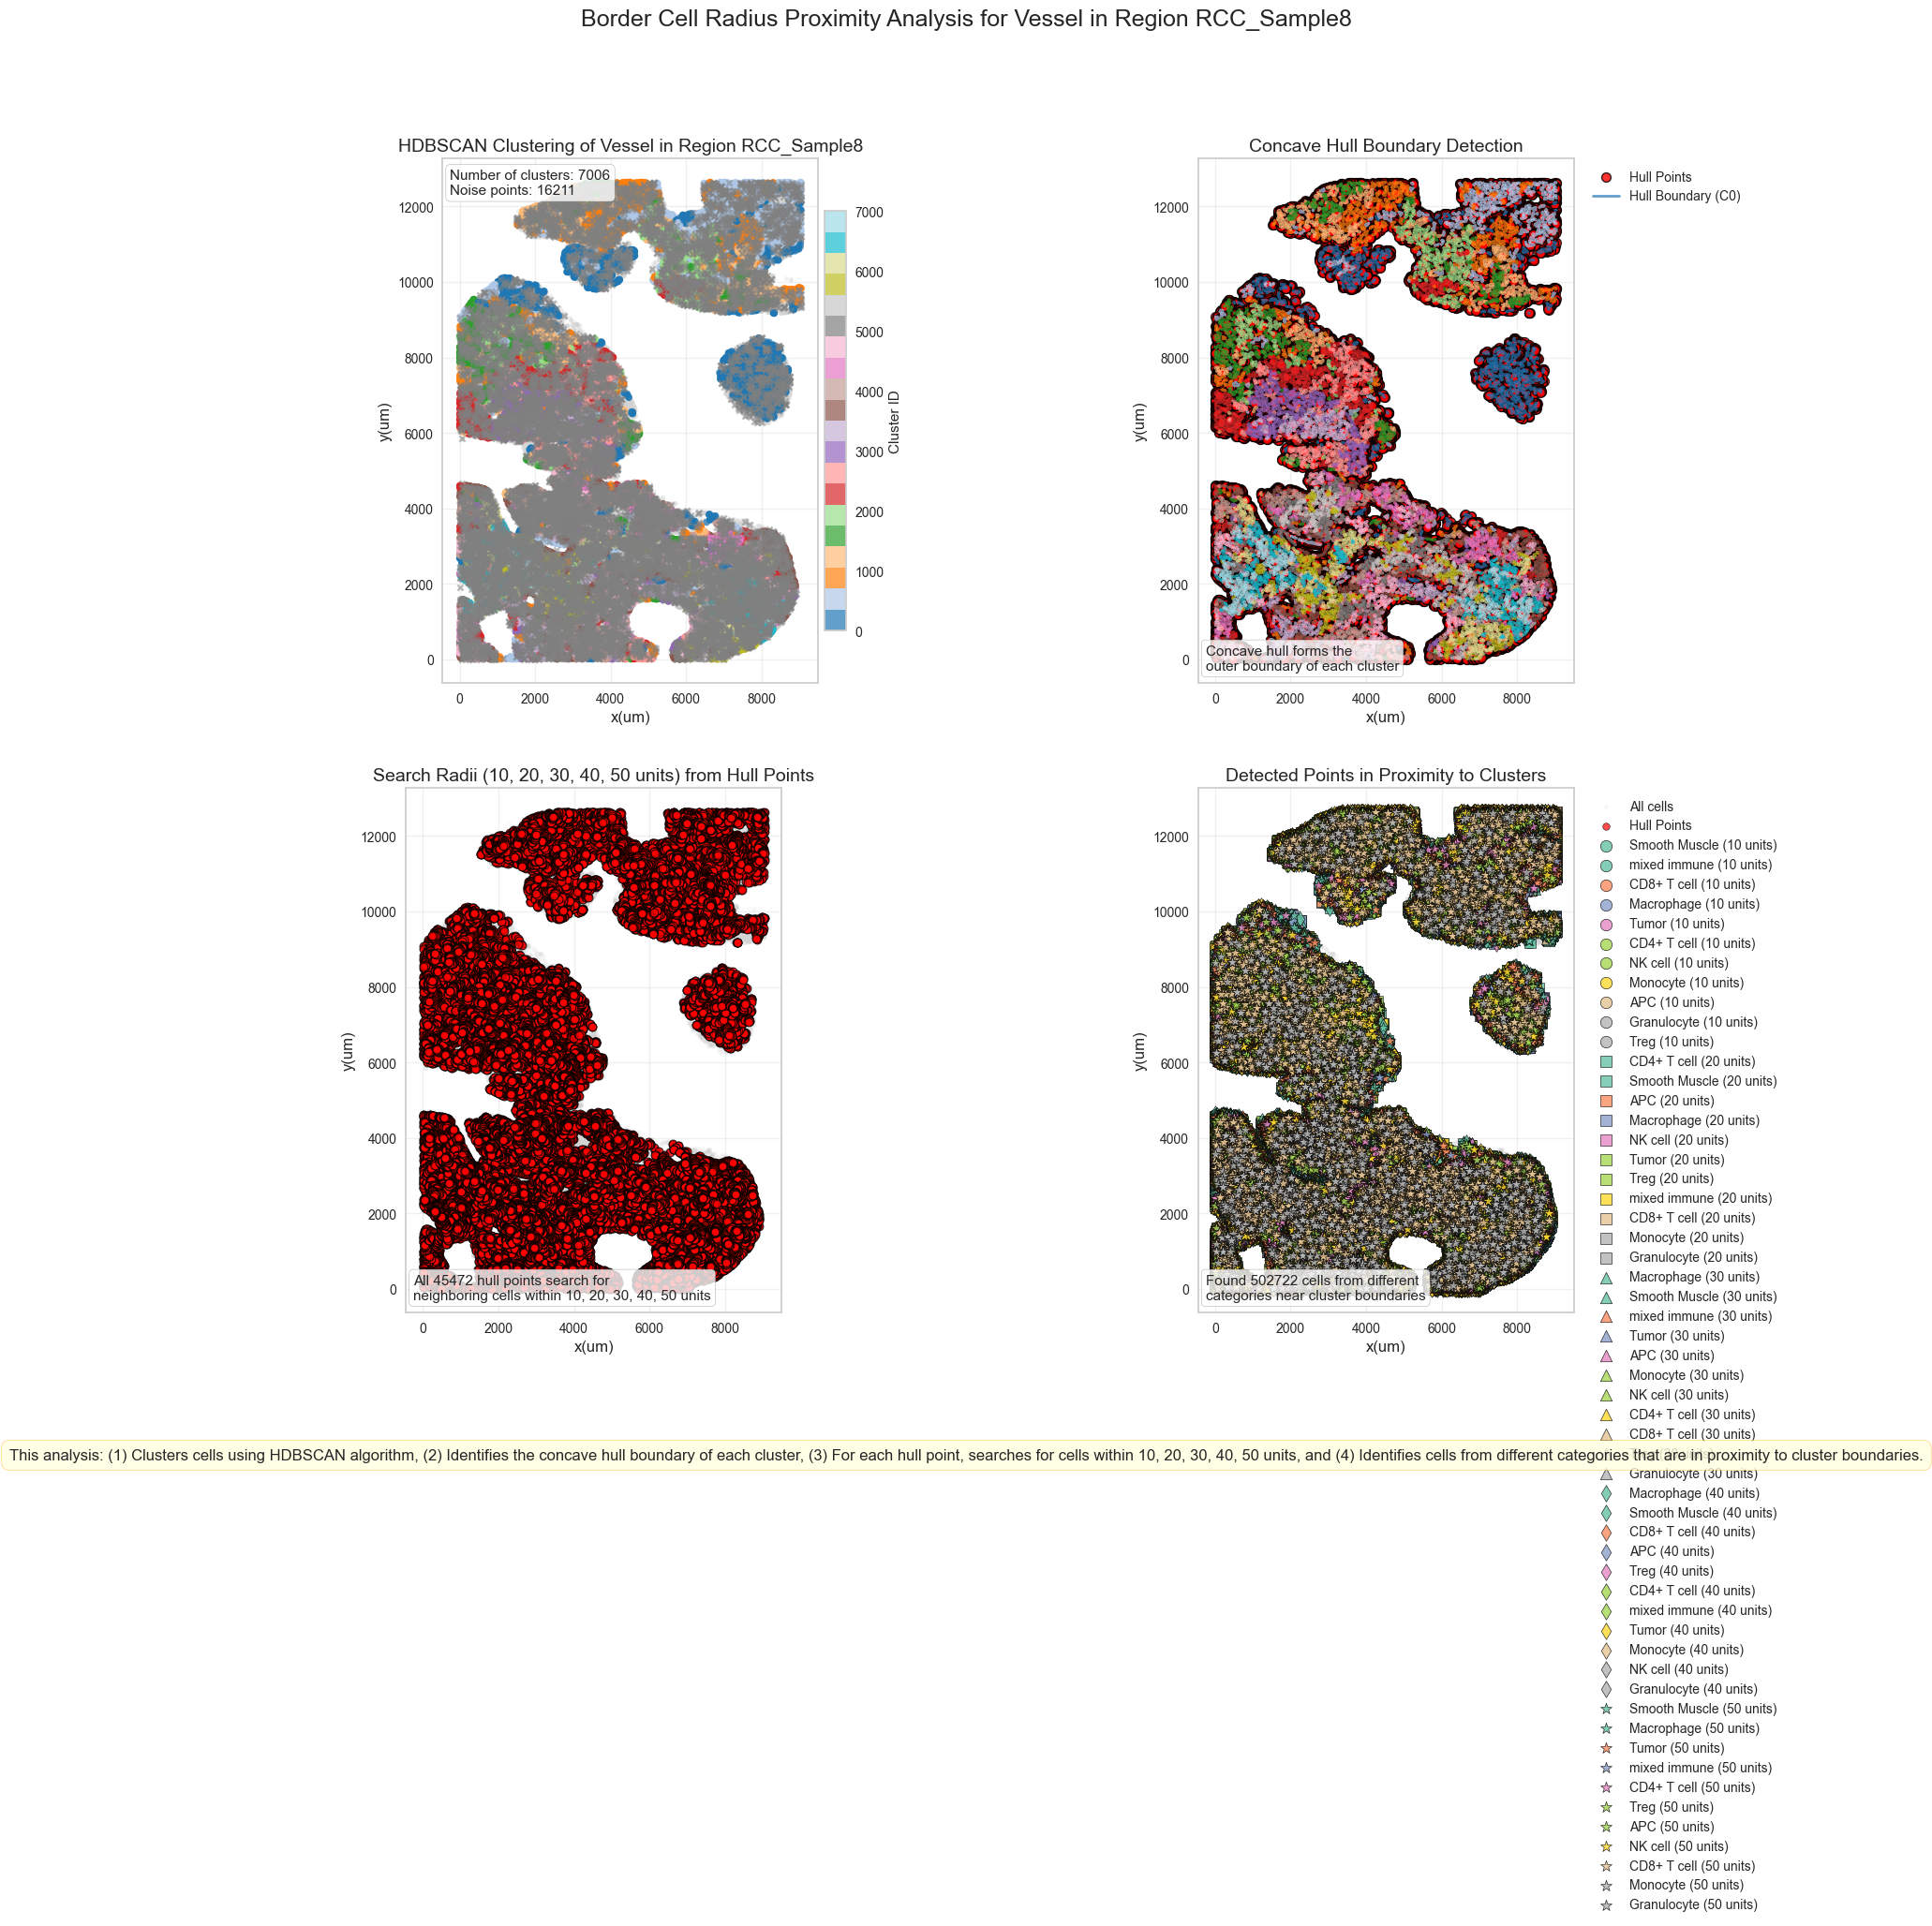

In [4]:
# this region result is also saved to adata.uns
results, outlines_results = sp.tl.patch_proximity_analysis(
    adata, # the annotated adata object
    region_column = "unique_region", # column with the region information
    patch_column = "cell_type", # column with the patch information (derive patches from this column)
    group="Vessel", # group to consider
    min_cluster_size=3, # minimum cluster size to consider
    x_column='x(um)', y_column='y(um)', # spatial coordinates
    radius = [10, 20, 30, 40, 50], # to get the distance in µm
    edge_neighbours = 1, # number of neighbours to consider for edge detection if set to 1 only the hull is considered
    plot = True, # plot the results for demonstration and/or documentation (set to False to skip plotting - improves speed)
    original_unit_scale = 1, # scale factor for the units (1 = 1px per unit e.g. µm)
    method= "border_cell_radius", # method to use for the edge detection
    key_name = "ppa_result_20_40_60_80_100_border_cell_radius", # key name to store the result in adata.uns
    save_geojson = False, # save the results as geojson
    ) # plot detection for demonstration purposes

Creating visualization for unique_region = RCC_Sample4
Radius 10: 32951 cells
Radius 20: 115328 cells
Radius 30: 194984 cells
Radius 40: 277954 cells
Radius 50: 369590 cells
Creating visualization for unique_region = RCC_Sample8
Radius 10: 41798 cells
Radius 20: 150552 cells
Radius 30: 257863 cells
Radius 40: 372736 cells
Radius 50: 502722 cells


{'RCC_Sample4': <Figure size 1000x1000 with 1 Axes>,
 'RCC_Sample8': <Figure size 1000x1000 with 1 Axes>}

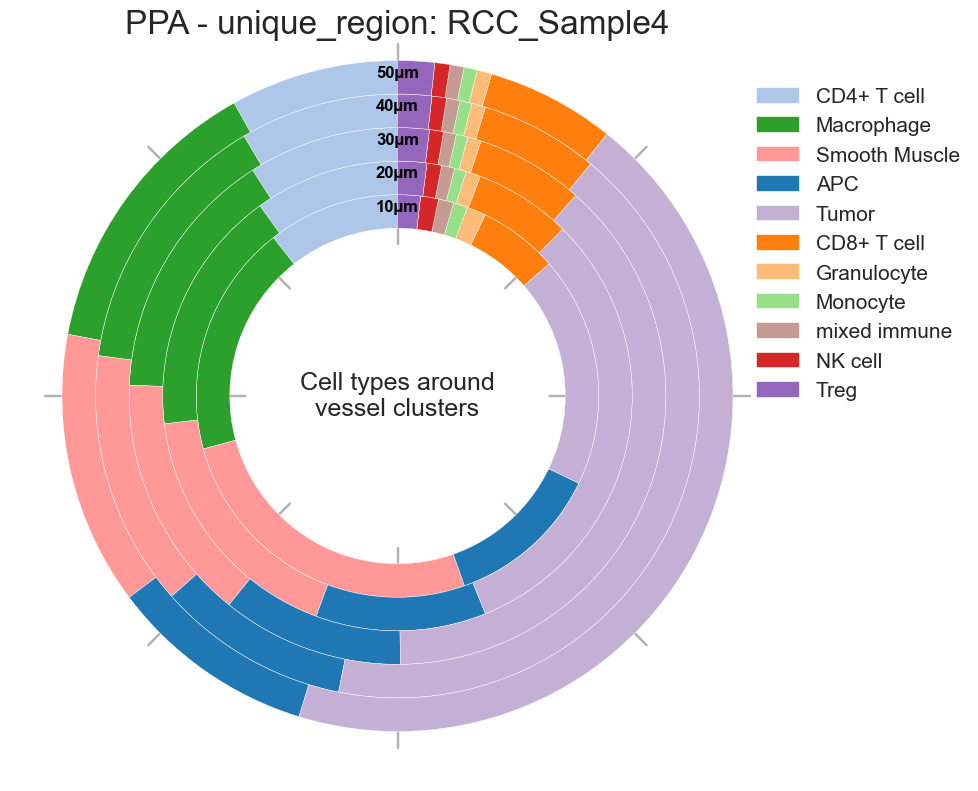

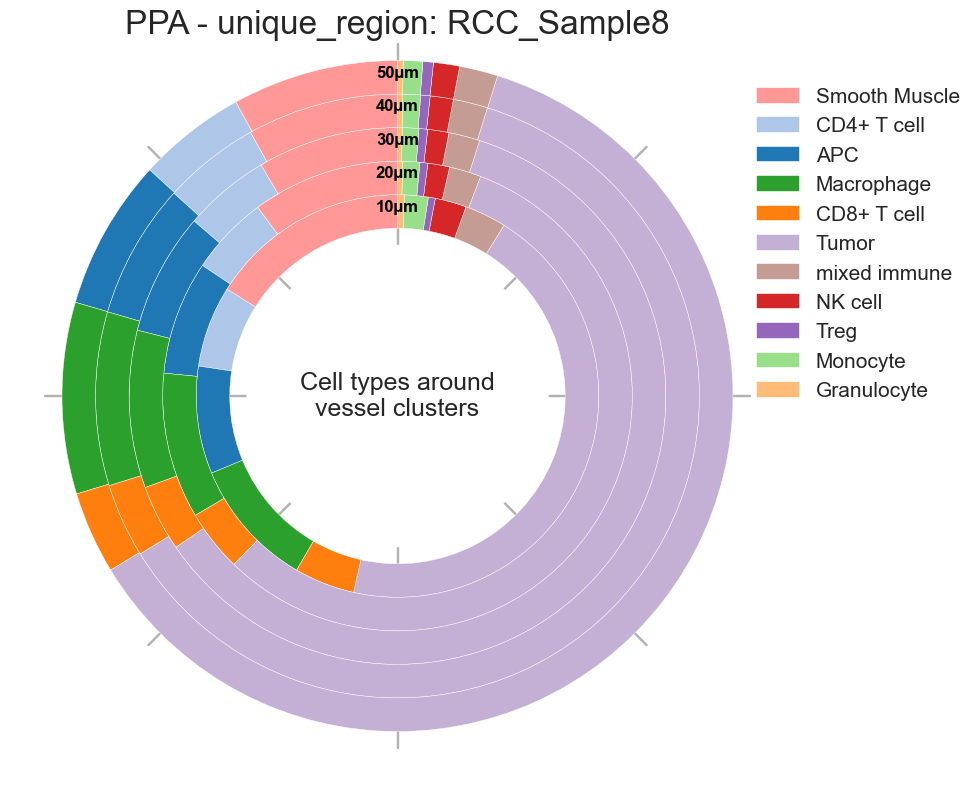

In [7]:
# Donut plots for cell types around Germinal Center
sp.pl.ppa_res_donut(
    adata,
    cat_col = 'cell_type',
    key_name="ppa_result_20_40_60_80_100_border_cell_radius",
    palette=None,
    distance_mode="within",  # "within" or "between"
    unit="µm",
    figsize=(10, 10),
    add_guides=True,
    text="Cell types around vessel clusters",
    label_color="black",
    group_by= 'unique_region',
    title="PPA",
    savefig=True,
    output_dir=output_dir,  # Specify your output directory
) 